In [1]:
# Speech_Augmentation_P5_org300_assignment_jupyter_Colab
# Sept 19, 2023
# Person X
!pip install python_speech_features
mode = 'colab'  # mode = 'jupyter' if used in "jupyter notebook"

if mode == 'colab' :
  from google.colab import drive
  drive.mount('/content/drive')

import tensorflow as tf
import pathlib
import re
import pickle
import os
from datetime import datetime

import matplotlib.pyplot as plt
import matplotlib.image as imgshow
import numpy as np

import random  # for randint()
from random import randint
# Set seed for experiment reproducibility
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)

import wave
from scipy.io import wavfile
from scipy.io.wavfile import write
#for loading and visualizing audio files
import librosa
import librosa.display
from matplotlib.pyplot import specgram
import soundfile as sf

# Import CNN libraries
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras import layers
from tensorflow.keras import models
from IPython import display
from keras.utils import to_categorical

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import utils
from tensorflow.keras.models import load_model

  Preparing metadata (setup.py) ... done
  Created wheel for python_speech_features: filename=python_speech_features-0.6-py3-none-any.whl size=5872 sha256=8325cfb2eacaccbd76feedada247cae2d0d697e1a4619b9708b93c2bf7afe05e
  Stored in directory: /root/.cache/pip/wheels/5a/9e/68/30bad9462b3926c29e315df16b562216d12bdc215f4d240294
Successfully built python_speech_features
Mounted at /content/drive


In [2]:
# STEP 1 : the keyword directories

commands= ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9','A','B','C','D','E','F','G','H','I','J','K','L','M','N','O','P','Q','R','S','T','U','V','W','X','Y','Z','!',',','+','(',')','$','%','#','@','&']

print('Number of command keywords : ',len(commands))



Number of command keywords :  46


In [3]:
# STEP 2A:  python functions defined for the program
#
# Just Click to continue (No need to modify !)

# Convert the waveform to have 72000 (1.5 seconds) data points
def covert_72000(waveform):  # Standardize to length of 72000; 1.5 SECONDS
  # if more than 72000, trim to 72000
  if (len(waveform) >= 72000):
    waveform = waveform[0:72000]
  # Padding for files with less than 72000 samples
  zero_padding = tf.zeros([72000] - tf.shape(waveform), dtype=tf.float32)

  # Concatenate audio with padding so that all audio clips will be of the same length
  waveform = tf.cast(waveform, tf.float32)  # NO NEED TO DOUBLE CAST
  equal_length = tf.concat([waveform, zero_padding], 0)
  return equal_length

# get_old_spectrogram by tf.signal.stft
def get_old_spectrogram(filename,samplerate,SHOW):
    samplerate, waveform = wavfile.read(filename)
    waveform72000 = covert_72000(waveform)
    spectrogram = tf.signal.stft(waveform72000, frame_length=255, frame_step=128)
    spectrogram = tf.abs(spectrogram)
    spectrogram_numpy = spectrogram.numpy()
    X = tf.abs(spectrogram_numpy)
    #print(X.shape)


    # One figure is shown:
    #fig, axes = plt.subplots(figsize=(12, 4))
    #cmaps =['RdBu_r', 'viridis']
    #im = axes.pcolormesh(spectrogram_numpy.T, cmap = cmaps[1])
    #axes.set_title('figure 1')
    #fig.colorbar(im,location = 'right')
    #plt.show


    if (SHOW == 1):
      #
      fig, axes = plt.subplots(3, figsize=(12, 12))
      timescale = np.arange(waveform72000.shape[0])
      # axes[0].plot(timescale, waveform.numpy())
      axes[0].plot(timescale, waveform72000)  #.tolist()
      axes[0].set_title('Original Waveform')
      axes[0].set_xlim([0, 72000])
      axes[0].set_ylim([-2, 2])  # axes[0].set_ylim([-0.5, 0.5])

      # Second figure is shown: Transpose of Spectrogram is needed
      cmaps =['RdBu_r', 'viridis']
      im = axes[1].pcolormesh(spectrogram_numpy.T, cmap = cmaps[1])
      axes[1].set_title('Figure 2')
      fig.colorbar(im,location = 'right')


      # Third figure is shown:
      bb=spectrogram_numpy
      log_spec = np.log(bb.T)  # The ln version
      # DO NOT USE log_spec = bb.T  # Withput ln version
      height = log_spec.shape[0]
      width = log_spec.shape[1]
      Xaxis = np.linspace(0, np.size(spectrogram), num=width, dtype=int)
      Yaxis = range(height)
      axes[2].pcolormesh(Xaxis,Yaxis,log_spec)
      axes[2].set_title('log spectrogram')
      axes[2].set_xlim([0, 72000])

      print('max/min(spectrogram_numpy): ',np.max(spectrogram_numpy), np.min(spectrogram_numpy))
      print('max/min(log_spec): ', np.max(log_spec),np.min(log_spec))
      plt.show

    return X


# get_new_spectrogram by librosa.stft
def get_new_spectrogram(filename,samplerate,SHOW):

    signal, sr = librosa.load(filename, sr=samplerate)

    signal = covert_72000(signal)
    signal = signal.numpy()  # need this after conversion
    #print('len(signal) after cast = ',len(signal),type(signal))

    # Step to Convert audio waveform to spectrogram
    # Spectrogram only make use of 256 rows, for frequencies to around 10K Hz.
    X = abs(librosa.stft(signal,n_fft=1024))
    # print('X.shape ',X.shape)  # gives (513,282) after the wav is 1.5 seconds
    X = X[0:256,:]  # gives (256,282)

    if (SHOW ==1):
      # Figure 1 : waveform
      plt.figure(figsize=(12, 4))
      librosa.display.waveshow(signal, sr=sr)
      plt.title('waveform : '+filename)
      plt.show()
      # Figure 2 : X
      plt.figure(figsize=(12, 4))
      librosa.display.specshow(X, sr=sr, y_coords=None, x_axis='time', y_axis=None)  #y_axis='hz'
      y_ticks=[1,15,50,100,155,255]
      y_labels=['43Hz','645Hz','2153Hz','4306Hz','6675Hz','10982Hz']
      plt.yticks(ticks=y_ticks, labels=y_labels)
      plt.colorbar()
      plt.title('X : '+filename)
      plt.show()
      # Figure 3 : Xdb
      Xdb = librosa.amplitude_to_db(X)
      plt.figure(figsize=(12, 4))
      librosa.display.specshow(Xdb, sr=sr, y_coords=None, x_axis='time', y_axis=None)  #y_axis='hz'
      y_ticks=[1,15,50,100,155,255]
      y_labels=['43Hz','645Hz','2153Hz','4306Hz','6675Hz','10982Hz']
      plt.yticks(ticks=y_ticks, labels=y_labels)
      plt.colorbar()
      plt.title('Xdb : '+filename)

      print('max/min(X): ',np.max(X), np.min(X))
      print('max/min(Xdb): ', np.max(Xdb),np.min(Xdb))
      plt.show()

    return X



# for display of spectrogram, return two elements
def get_spectrogram(waveform):  # Standardize to length of 5000; around ONE SECOND
  # if more than 50000, trim to 50000
  if (len(waveform) >= 50000):
    waveform = waveform[0:50000]
  # Padding for files with less than 50000 samples
  zero_padding = tf.zeros([50000] - tf.shape(waveform), dtype=tf.float32)

  # Concatenate audio with padding so that all audio clips will be of the
  # same length
  waveform = tf.cast(waveform, tf.float32)
  equal_length = tf.concat([waveform, zero_padding], 0)
  spectrogram = tf.signal.stft(
      equal_length, frame_length=255, frame_step=128)

  spectrogram = tf.abs(spectrogram)

  return spectrogram, equal_length

def plot_spectrogram_axes(spectrogram, ax): ###
  # Convert to frequencies to log scale and transpose so that the time is
  # represented in the x-axis (columns).
  log_spec = np.log(spectrogram.T)
  height = log_spec.shape[0]
  width = log_spec.shape[1]
  X = np.linspace(0, np.size(spectrogram), num=width, dtype=int)
  Y = range(height)
  ax.pcolormesh(X, Y, log_spec)

def plot_spectrogram(znew,figtitle):
    fig, axes = plt.subplots(figsize=(12, 4))
    cmaps =['RdBu_r', 'viridis']

    im = axes.pcolormesh(znew.T, cmap = cmaps[1])
    axes.set_title(figtitle)
    fig.colorbar(im,location = 'right')

    plt.show





In [4]:
# STEP 2B:  more python functions defined for the program
#
# Just Click to continue (No need to modify !)

# A function to read an audio .wav file and shows the waveform
def showAudio(file_name,SHOW):
  audio_binary = tf.io.read_file(file_name)
  audio , sampleR = tf.audio.decode_wav(audio_binary)
  waveform2=audio.numpy()
  if (waveform2.shape[1] == 1):
    waveform1=waveform2
  else:
    waveform1=waveform2[:,1] #stereo changed to mono
  if (SHOW):
    figure(figsize=(25, 15),dpi=40)
    plt.plot(waveform1)
    plt.axes()
    plt.title(file_name)
  return waveform1

# Dec 28, 2022 Modify for better segmentation results
#--------------------------------------------------
def get_waveform_section_v2(file_name, Z, SHOW):
  audio_binary = tf.io.read_file(file_name)
  audio , sampleR = tf.audio.decode_wav(audio_binary)
  waveform2=audio.numpy()  # may be mono or stereo
  if (waveform2.shape[1] == 1):
    waveform1=waveform2
  else:
    waveform1=waveform2[:,1] #stereo changed to mono

  waveformN= np.zeros((len(waveform1)),dtype=float)
  for i in range(0,(len(waveform1)-Z)):
    tmpVal = np.max(np.abs(waveform1[i:i+Z]))
    # threshold to 0.035 from 0.05; helps when sound is low; on May 24, 2022
    if (tmpVal > 0.03): # threshold to 0.03 ; helps when sound is low; on Dec 28, 2022
      waveformN[i]=0.8
    else:
      waveformN[i]=0

  for i in range(len(waveform1)-Z,len(waveform1)):
    waveformN[i]=0

  # Check for suitable audio sections
  audioLength=[]
  audioLength_section=[]
  xcoords = []
  colors = []
  Astart=-1
  Astop=-1
  for i in range(len(waveform1)-10):
    if (waveformN[i] == 0 and waveformN[i+1] == 0.8):
      Astart=i
    if (waveformN[i] == 0.8 and waveformN[i+1] == 0):
      Astop=i
      if (Astart != -1):
        Aduration = Astop - Astart
        # print('Aduration (expected to longer than 0.2sec or 9000) = ',Aduration)
        # changed to 11500 on Sept 29, 2022
        # Dec 28, 2022 : Astop + 5000 (to get better ending of a .wav)
        if (Aduration > 11500):
          audioLength = audioLength + ([Aduration])
          xcoords = xcoords +([Astart , Astop+5000])
          Actual_duration = Astop + 5000 - Astart
          if (Actual_duration > 72000):
            print('*********************** warning LONG audio section ******* = ', Actual_duration, ' fileanme ',file_name)
          audioLength_section = audioLength_section + ([Actual_duration])
          colors = colors + (['r','g'])
          Astart = -1
          Astop = -1
  print('length of audioLength ',audioLength_section)

  if (SHOW == 1):
    figure(figsize=(20, 10),dpi=40)
    plt.plot(waveform1)

    for i in range(0,int(len(xcoords)/2)):
      xc1 =xcoords[2*i]
      xc2 =xcoords[2*i+1]
      tmp1=str(i+1)+'a' # to display a label next to the vertical line
      tmp2=str(i+1)+'b' # to display a label next to the vertical line
      plt.axvline(x=xc1, ymin=0.2, ymax=0.8, linewidth = 2,color=colors[2*i],linestyle = '--')
      plt.text(xc1,0.2,tmp1,fontsize=20)
      plt.axvline(x=xc2, ymin=0.2, ymax=0.8, linewidth = 2,color=colors[2*i+1],linestyle = '--')
      plt.text(xc2,0.2,tmp2,fontsize=20)
      plt.grid(True)

    #plt.axes() #this will create an error message
    plt.title('Audio obtained',fontsize=40)
    plt.xlabel('time',fontsize=40)
    plt.ylabel('magnitude',fontsize=40)
    plt.show()


  if (SHOW == 3):
    print('audioLength ',audioLength)
    print('xcoords ',xcoords)
    print('colors ',colors)

    # Next, I would like to show three figures.
    #
    fig, axes = plt.subplots(3, figsize=(20, 16))
    # timescale = np.arange(waveform.shape[0])
    # axes[0].plot(timescale, waveform.numpy())
    axes[0].plot(waveform1.tolist())
    axes[0].set_title('Waveform')
    #axes[0].set_xlim([0, len(waveform1)])
    #axes[0].set_ylim([-1, 1])

    axes[1].plot(waveformN.tolist())
    axes[1].set_title('waveformN')
    #axes[0].set_xlim([0, len(waveform1)])
    #axes[0].set_ylim([-1, 1])

    axes[2].plot(waveform1.tolist())
    #axes[2].set_title('Audio Sections')
    #axes[2].set_xlim([0, len(waveform1)])
    #axes[2].set_ylim([-1, 1])


    for i in range(0,int(len(xcoords)/2)):
      xc1 =xcoords[2*i]
      xc2 =xcoords[2*i+1]
      tmp1=str(i+1)+'a' # to display a label next to the vertical line
      tmp2=str(i+1)+'b' # to display a label next to the vertical line
      plt.axvline(x=xc1, ymin=0.2, ymax=0.8, linewidth = 2,color=colors[2*i],linestyle = '--')
      plt.text(xc1,0.5,tmp1)
      plt.axvline(x=xc2, ymin=0.2, ymax=0.8, linewidth = 2,color=colors[2*i+1],linestyle = '--')
      plt.text(xc2,0.5,tmp2)
      plt.grid(True)
    plt.show()

  return xcoords, colors

def resolve(waveform1,xcoords):
  # print('Enter resolve: ',waveform1.shape, ' xcoords = ',xcoords)
  if (len(xcoords) != 0):
    ### Number of AUDIO SECTION is THREE
    # xcoordsW = xcoords  # true in general
    if (int(len(xcoords)/2) == 3):
      xcoordsW = xcoords
      # NEW approach: do not modify using get_xcoordsW_v2
      # xcoordsW = get_xcoordsW_v2(waveform1,xcoords, 10000,5000)

    ### Number of AUDIO SECTION is TWO
    if (int(len(xcoords)/2) == 2):
      print('number of AUDIO SECTION is TWO. ')
      aa=xcoords[0]
      bb=xcoords[len(xcoords)-1]

      Length_1st = xcoords[1] - xcoords[0]
      Length_2nd = xcoords[3] - xcoords[2]

      if (Length_1st > Length_2nd):
        Middle_1st_index = xcoords[0] + int(0.5*Length_1st)
        tmpVal1 = findmin(waveform1, int(Middle_1st_index - Length_1st*0.25), int(Middle_1st_index + Length_1st*0.25) )
        xcoordsW = [ aa , tmpVal1, tmpVal1, xcoords[1], xcoords[2] , bb]
        #print('search range',int(Middle_1st_index - Length_1st*0.25), int(Middle_1st_index + Length_1st*0.25))
        #print('Length_1st Middle_1st_index tmpVal1 ',Middle_1st_index ,tmpVal1)
        print('xcoordsW',xcoordsW)

      if (Length_1st <= Length_2nd):
        Middle_2nd_index = xcoords[2] + int(0.5*Length_2nd)
        tmpVal2 = findmin(waveform1, int(Middle_2nd_index - Length_2nd*0.25), int(Middle_2nd_index + Length_2nd*0.25) )
        xcoordsW = [ aa , xcoords[1], xcoords[2], tmpVal2, tmpVal2 , bb]
        #print('search range',int(Middle_2nd_index - Length_2nd*0.25), int(Middle_2nd_index + Length_2nd*0.25))
        #print('Length_2nd Middle_2nd_index  tmpVal2',Middle_2nd_index ,tmpVal2)
        print('xcoordsW',xcoordsW)

    ### Number of AUDIO SECTION is ONE
    if (int(len(xcoords)/2) == 1):
      print('number of AUDIO SECTION is ONE. ')
      aa=xcoords[0]
      bb=xcoords[1]
      dd=int(bb-aa)
      tmpVal1 = findmin(waveform1,int(aa+dd/3 - dd/9),int(aa+dd/3 + dd/9) )
      #print('tmpVal1 search range',int(aa+dd/3 - dd/9),int(aa+dd/3 + dd/9),tmpVal1)
      tmpVal2 = findmin(waveform1,int(aa+dd*2/3 - dd/9),int(aa+dd*2/3 + dd/9) )
      #print('tmpVal2 search range',int(aa+dd*2/3 - dd/9),int(aa+dd*2/3 + dd/9),tmpVal2)
      xcoordsW = [ aa , tmpVal1, tmpVal1, tmpVal2, tmpVal2 , bb]
      print('xcoordsW',xcoordsW)

    ### Number of AUDIO SECTION is FOUR
    ##  OLD code is to keep only the largest 3 sections
    if (int(len(xcoords)/2) == 4):
      xcoordsW = []
      print('number of AUDIO SECTION is FOUR. ')
      gap_1st = xcoords[2] - xcoords[1]
      gap_2nd = xcoords[4] - xcoords[3]
      gap_3rd = xcoords[6] - xcoords[5]
      x=np.array([ gap_1st, gap_2nd, gap_3rd])
      index_tmp=np.argsort(x)
      if (index_tmp[0]==0):
        xcoordsW = [ xcoords[0] ,xcoords[3], xcoords[4],xcoords[5],xcoords[6],xcoords[7] ]
      if (index_tmp[0]==1):
        xcoordsW = [ xcoords[0] ,xcoords[1], xcoords[2],xcoords[5],xcoords[6],xcoords[7] ]
      if (index_tmp[0]==2):
        xcoordsW = [ xcoords[0] ,xcoords[1], xcoords[2],xcoords[3],xcoords[4],xcoords[7] ]
      print('xcoordsW',xcoordsW)


    ### Number of AUDIO SECTION is FIVE
    # OLD code was to keep only the largest 3 sections
    if (int(len(xcoords)/2) == 5):
      xcoordsW = []
      print('number of AUDIO SECTION is FIVE. ')
      gap_1st = xcoords[2] - xcoords[1]
      gap_2nd = xcoords[4] - xcoords[3]
      gap_3rd = xcoords[6] - xcoords[5]
      gap_4th = xcoords[8] - xcoords[7]
      x=np.array([ gap_1st, gap_2nd, gap_3rd, gap_4th])
      index_tmp=np.argsort(x)
      goodindex = np.array([index_tmp[0],index_tmp[1]])
      if (0 in goodindex and 1 in goodindex):
        xcoordsW = [xcoords[0],xcoords[5],xcoords[6],xcoords[7],xcoords[8],xcoords[9]]
      if (0 in goodindex and 2 in goodindex):
        xcoordsW = [xcoords[0],xcoords[3],xcoords[4],xcoords[7],xcoords[8],xcoords[9]]
      if (0 in goodindex and 3 in goodindex):
        xcoordsW = [xcoords[0],xcoords[3],xcoords[4],xcoords[5],xcoords[6],xcoords[9]]
      if (1 in goodindex and 2 in goodindex):
        xcoordsW = [xcoords[0],xcoords[1],xcoords[2],xcoords[7],xcoords[8],xcoords[9]]
      if (1 in goodindex and 3 in goodindex):
        xcoordsW = [xcoords[0],xcoords[1],xcoords[2],xcoords[5],xcoords[6],xcoords[9]]
      if (2 in goodindex and 3 in goodindex):
        xcoordsW = [xcoords[0],xcoords[1],xcoords[2],xcoords[3],xcoords[4],xcoords[9]]
      print('xcoordsW',xcoordsW)


    ### Number of AUDIO SECTION is SIX
    if (int(len(xcoords)/2) == 6):
      # Keep only the largest 3 sections
      xcoordsW = []
      print('number of AUDIO SECTION is SIX. Keep largest 3 sections.')
      Length_1st = xcoords[1] - xcoords[0]
      Length_2nd = xcoords[3] - xcoords[2]
      Length_3rd = xcoords[5] - xcoords[4]
      Length_4th = xcoords[7] - xcoords[6]
      Length_5th = xcoords[9] - xcoords[8]
      Length_6th = xcoords[11] - xcoords[10]

      x=np.array([ Length_1st, Length_2nd, Length_3rd, Length_4th, Length_5th, Length_6th])
      index_tmp=np.argsort(x)
      #print(x)
      #print(index)
      goodindex = np.array([index_tmp[3],index_tmp[4],index_tmp[5]])
      #print('goodindex = ',goodindex)


      if (0 in goodindex):
        #print('section 1 okay')
        xcoordsW = xcoordsW + [xcoords[0],xcoords[1]]

      if (1 in goodindex):
        #print('section 2 okay')
        xcoordsW = xcoordsW + [xcoords[2],xcoords[3]]

      if (2 in goodindex):
        #print('section 3 okay')
        xcoordsW = xcoordsW + [xcoords[4],xcoords[5]]

      if (3 in goodindex):
        #print('section 4 okay')
        xcoordsW = xcoordsW + [xcoords[6],xcoords[7]]

      if (4 in goodindex):
        #print('section 5 okay')
        xcoordsW = xcoordsW + [xcoords[8],xcoords[9]]

      if (5 in goodindex):
        #print('section 6 okay')
        xcoordsW = xcoordsW + [xcoords[10],xcoords[11]]
      print('xcoordsW',xcoordsW)


    #print('Exit resolve: ',waveform1.shape, ' xcoords = ',xcoords)
  else:
    print('ERROR:len(xcoords) is zero in resolve()')

  return xcoordsW

def ShowAudioSectionX2(waveform1,xcoords,xcoordsW,colors):
  plt.figure(figsize=(20, 8))
  plt.plot(waveform1.tolist())
  plt.title('Waveform')
  for i in range(0,int(len(xcoords)/2)):
    xc1 =xcoords[2*i]
    xc2 =xcoords[2*i+1]
    # tmp1=str(i+1)+'a' # to display a label next to the dotted vertical line
    # tmp2=str(i+1)+'b' # to display a label next to the dotted vertical line
    plt.axvline(x=xc1, ymin=0.2, ymax=0.8, linewidth = 2,color=colors[2*i],linestyle = '--')
    # plt.text(xc1,0.5,tmp1)
    plt.axvline(x=xc2, ymin=0.2, ymax=0.8, linewidth = 2,color=colors[2*i+1],linestyle = '--')
    # plt.text(xc2,0.5,tmp2)

    xc1 =xcoordsW[2*i]
    xc2 =xcoordsW[2*i+1]
    tmp1=str(i+1)+'a' # to display a label next to the vertical line
    tmp2=str(i+1)+'b' # to display a label next to the vertical line
    plt.axvline(x=xc1, ymin=0.2, ymax=0.8, linewidth = 2,color=colors[2*i])
    plt.text(xc1,0.5,tmp1)
    plt.axvline(x=xc2, ymin=0.2, ymax=0.8, linewidth = 2,color=colors[2*i+1])
    plt.text(xc2,0.5,tmp2)

    plt.grid(True)
  plt.show()

def findmin(waveform,start_index,end_index):
  print('**** findmin() start_index,end_index  = ',start_index,end_index)

  waveformN=1.5*np.zeros(end_index - start_index,dtype=float)
  # To get the largest within the next 1000 data
  for i in range(0,len(waveformN)):
    waveformN[i] = np.max(np.abs(waveform[i+start_index:i+start_index+1000]))

  save_x = -1
  tmp = waveformN[0]
  # Next, we want to find the lowest within the section
  for i in range(0, len(waveformN)):
    if (waveformN[i] < tmp):
      tmp = waveformN[i]
      save_x = i
  answer_x = save_x + start_index
  print('**** findmin()  answer_x = ',answer_x)
  return answer_x

In [ ]:
# MAIN Program Below:

In [5]:
# STEP 3:
# Get a list of all the files in the training and testing dataset directory
################################################################

if mode == 'jupyter':
    train_data_dir = 'D:\gpang\CroucherProject\Evaluation\dataset-P5-20230810-org300'
    test_data_dir = 'D:\gpang\CroucherProject\Evaluation\dataset-Test-P5-20230810-org300'

if mode == 'colab' :
    train_data_dir = "/content/drive/My Drive/Colab Notebooks/dataset-P2-20230207-aug4240"
    test_data_dir = "/content/drive/My Drive/dataset-Test-P2-20230207-org200"

print('train_data_dir:',str(train_data_dir))
filenames = tf.io.gfile.glob(str(train_data_dir)+'/*')
print('Number of folders: len(filenames)',len(filenames))
print(filenames[0])

print(' Number of folders: ',len(filenames))

iii=0
for kk in range(len(commands)):
  tmp_names = tf.io.gfile.glob(str(train_data_dir)+'/'+commands[kk]+'/*')
  iii=iii+len(tmp_names)
  print(commands[kk],'; Number of samples:',len(tmp_names))
print('total number of items = ',iii)

train_data_dir: /content/drive/My Drive/Colab Notebooks/dataset-P2-20230207-aug4240
Number of folders: len(filenames) 46
/content/drive/My Drive/Colab Notebooks/dataset-P2-20230207-aug4240/Z
 Number of folders:  46
0 ; Number of samples: 200
1 ; Number of samples: 60
2 ; Number of samples: 220
3 ; Number of samples: 60
4 ; Number of samples: 40
5 ; Number of samples: 60
6 ; Number of samples: 80
7 ; Number of samples: 170
8 ; Number of samples: 70
9 ; Number of samples: 50
A ; Number of samples: 90
B ; Number of samples: 90
C ; Number of samples: 70
D ; Number of samples: 80
E ; Number of samples: 130
F ; Number of samples: 90
G ; Number of samples: 50
H ; Number of samples: 60
I ; Number of samples: 140
J ; Number of samples: 80
K ; Number of samples: 50
L ; Number of samples: 80
M ; Number of samples: 50
N ; Number of samples: 30
O ; Number of samples: 110
P ; Number of samples: 100
Q ; Number of samples: 70
R ; Number of samples: 290
S ; Number of samples: 110
T ; Number of samples:

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [7]:
# STEP 4:  To listen to the audio file
if mode == 'jupyter':
    wavfileinput = "D:\gpang\CroucherProject\Code\sample_audio.wav"
if mode == 'colab' :
    wavfileinput = "/content/drive/My Drive/sample_audio.wav"

samplerate, waveform = wavfile.read(wavfileinput)
print('samplerate = ',samplerate)
print('filename: ',wavfileinput)

# the audio file will have the length of 50000 points (around 1 second) in new_waveform
spectrogram,  new_waveform = get_spectrogram(waveform)
spectrogram = spectrogram.numpy()

print('Waveform shape:', waveform.shape)
print('New Waveform shape:', new_waveform.shape)
print('Spectrogram shape:', spectrogram.shape)
print('Audio playback')
display.display(display.Audio(new_waveform, rate=samplerate))

samplerate =  48000
filename:  /content/drive/My Drive/sample_audio.wav
Waveform shape: (30457,)
New Waveform shape: (50000,)
Spectrogram shape: (389, 129)
Audio playback


<ipython-input-8-e381cb58989c>:12: RuntimeWarning: divide by zero encountered in log
  log_spec = np.log(spectrogram.T)


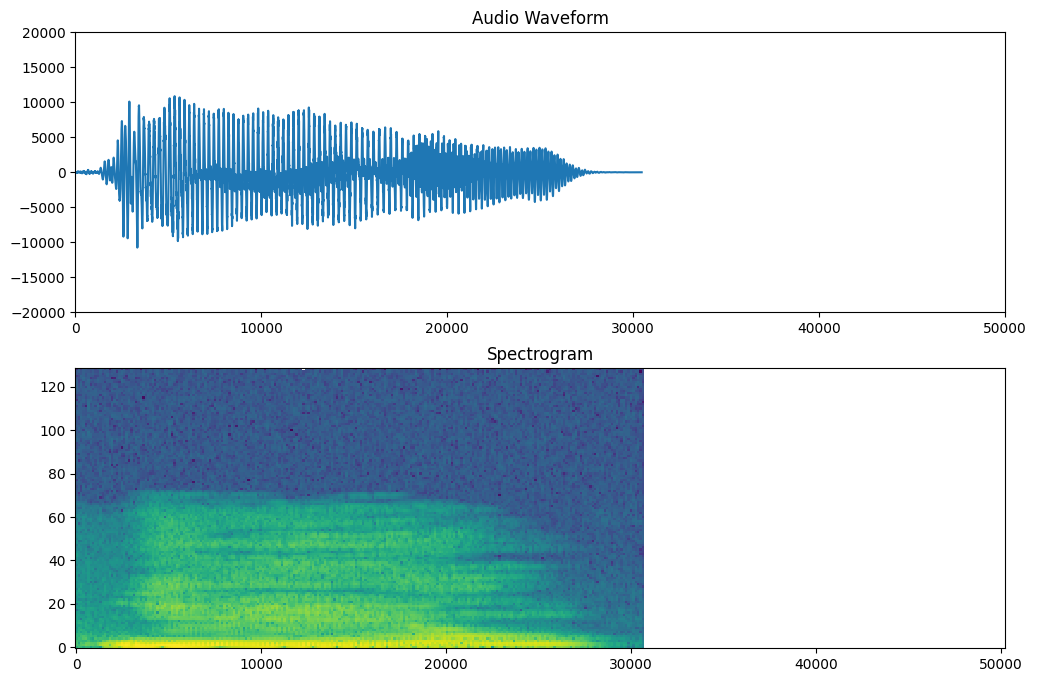

In [8]:
# Version A : two figures.
# To show the audio signal and spectrogram of the audio file
#
fig, axes = plt.subplots(2, figsize=(12, 8))
timescale = np.arange(waveform.shape[0])
# axes[0].plot(timescale, waveform.numpy())
axes[0].plot(timescale, waveform.tolist())
axes[0].set_title('Audio Waveform')
axes[0].set_xlim([0, 50000])
axes[0].set_ylim([-20000, 20000])

log_spec = np.log(spectrogram.T)
height = log_spec.shape[0]
width = log_spec.shape[1]
X = np.linspace(0, np.size(spectrogram), num=width, dtype=int)
Y = range(height)
axes[1].pcolormesh(X, Y, log_spec)
axes[1].set_title('Spectrogram')
plt.show()

<ipython-input-11-6d73b67e9f02>:18: UserWarning: amplitude_to_db was called on complex input so phase information will be discarded. To suppress this warning, call amplitude_to_db(np.abs(S)) instead.
  mfccs = librosa.feature.mfcc(S=librosa.amplitude_to_db(spectrogram), sr=sr, n_mfcc=20)


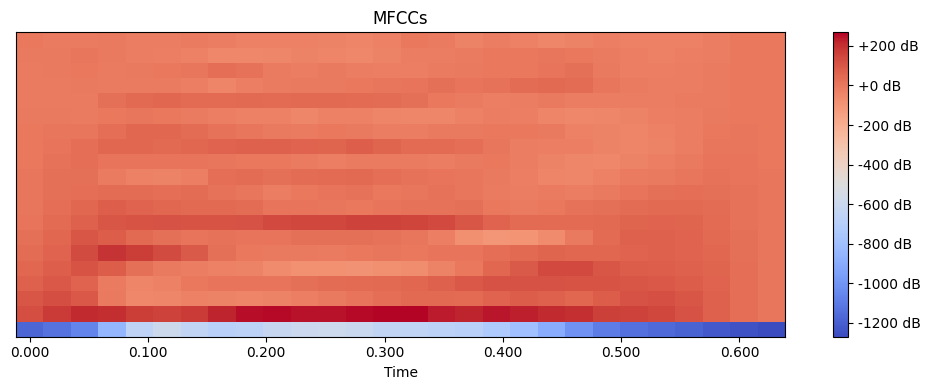

In [11]:
import scipy.io.wavfile as wavfile
import matplotlib.pyplot as plt
import numpy as np
from python_speech_features import mfcc

# To listen to the audio file
if mode == 'jupyter':
    wavfileinput = "D:\gpang\CroucherProject\Code\sample_audio.wav"
if mode == 'colab' :
    wavfileinput = "/content/drive/My Drive/sample_audio.wav"

y, sr = librosa.load(wavfileinput)

# Compute spectrogram
spectrogram = librosa.stft(y)

# Compute MFCCs from the spectrogram
mfccs = librosa.feature.mfcc(S=librosa.amplitude_to_db(spectrogram), sr=sr, n_mfcc=20)

# Display MFCCs
plt.figure(figsize=(10, 4))
librosa.display.specshow(mfccs, x_axis='time')
plt.colorbar(format='%+2.0f dB')
plt.title('MFCCs')
plt.tight_layout()
plt.show()

TypeError: ignored

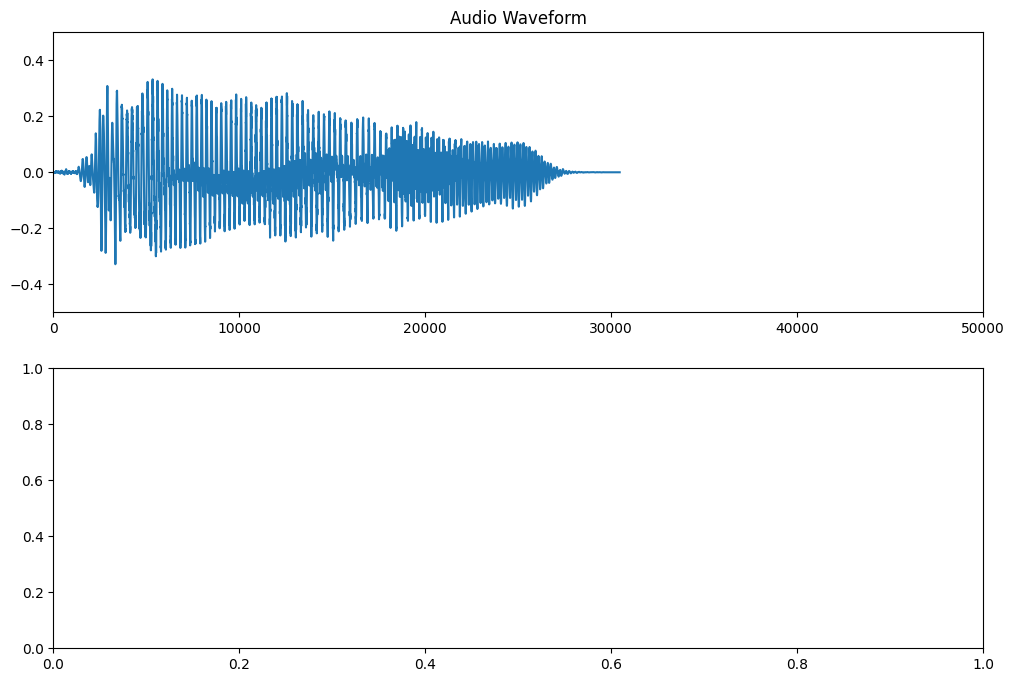

In [10]:
# Version B : two figures.
# To show the audio signal and spectrogram of the audio file

# The use of another routine to readin the audio file
waveform1 = showAudio(wavfileinput,0)

fig, axes = plt.subplots(2, figsize=(12, 8))
timescale = np.arange(waveform1.shape[0])
# axes[0].plot(timescale, waveform.numpy())
axes[0].plot(timescale, waveform1.tolist())
axes[0].set_title('Audio Waveform')
axes[0].set_xlim([0, 50000])
axes[0].set_ylim([-0.5, 0.5])


log_spec = np.log(spectrogram.T)
height = log_spec.shape[0]
width = log_spec.shape[1]
X = np.linspace(0, np.size(spectrogram), num=width, dtype=int)
Y = range(height)
axes[1].pcolormesh(X, Y, log_spec)
axes[1].set_title('Spectrogram')
plt.show()




In [12]:
# STEP 5: Get all the training files in all the 46 sub-directories, with labels
print('==========================================================================')
X_trainfiles=[]
Y_trainlabel=[]

for kk in range(len(commands)):
  tmp2=commands[kk]
  tmp1 = len(tf.io.gfile.listdir(train_data_dir+'/'+str(commands[kk])))
  #print('Command:  ',tmp2,  'Number of examples in label:',tmp1)

  tmp1string = str(train_data_dir) +'/'+ tmp2+'/*'
  #print(tmp1string)
  tmp1_trainfiles = tf.io.gfile.glob(tmp1string)

  # To get the label of the datafile
  tmp_trainlabel=[kk]*tmp1

  # To create the datafile
  X_trainfiles.extend(tmp1_trainfiles)
  Y_trainlabel.extend(tmp_trainlabel)


print('Total number of files in the training database:', len(Y_trainlabel))

#print('X_trainfiles = ',X_trainfiles)
print('Y_label = ',Y_trainlabel)


Total number of files in the training database: 4240
Y_label =  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,

In [13]:
# STEP 6: Randomize all the training files
###########################################################
# to randomize the labels of training file input

new_X_trainfiles = []
new_Y_trainlabel = []

print('Number of train files = ',len(X_trainfiles))
# shuttle the trainfilesIndex
indexItrain=[]
for i in range(len(X_trainfiles)):
  indexItrain.append(i)
indexItrain = tf.random.shuffle(indexItrain)
print('len(indexItrain) = ',len(indexItrain))
#print('indexItrain = ',indexItrain)

for kk in range(len(indexItrain)):
  newkk=int(indexItrain[kk])
  tmp_fileName = str(X_trainfiles[newkk])
  #print(tmp_fileName)
  new_X_trainfiles.append(tmp_fileName)
  new_Y_trainlabel.append(Y_trainlabel[newkk])

#print('new_X_trainfiles = ',new_X_trainfiles)
print('new_Y_label = ',new_Y_trainlabel)

X_trainfiles = new_X_trainfiles
Y_trainlabel = new_Y_trainlabel

Number of train files =  4240
len(indexItrain) =  4240
new_Y_label =  [2, 24, 20, 4, 16, 32, 21, 0, 2, 25, 29, 16, 28, 22, 25, 43, 0, 40, 39, 15, 39, 29, 45, 28, 27, 14, 27, 41, 41, 34, 34, 27, 41, 2, 28, 28, 26, 2, 33, 20, 21, 4, 10, 5, 38, 14, 39, 14, 45, 44, 7, 34, 34, 34, 2, 44, 27, 38, 29, 31, 2, 18, 4, 18, 41, 39, 35, 39, 27, 18, 32, 18, 2, 36, 12, 0, 7, 13, 7, 27, 18, 33, 10, 27, 12, 12, 35, 30, 18, 38, 21, 25, 43, 24, 6, 27, 25, 39, 41, 14, 8, 2, 27, 2, 21, 0, 14, 6, 2, 5, 39, 29, 18, 12, 39, 10, 2, 27, 8, 22, 34, 40, 7, 2, 27, 28, 42, 39, 33, 0, 39, 44, 36, 12, 1, 14, 36, 2, 22, 37, 7, 37, 39, 28, 27, 11, 14, 23, 3, 7, 45, 42, 18, 12, 24, 17, 33, 41, 27, 16, 29, 25, 3, 18, 17, 2, 45, 19, 6, 2, 0, 27, 18, 31, 30, 10, 2, 40, 12, 10, 20, 1, 7, 43, 0, 0, 27, 2, 17, 0, 36, 11, 36, 36, 31, 20, 10, 0, 27, 33, 7, 0, 32, 29, 26, 13, 27, 20, 36, 11, 15, 34, 21, 36, 12, 2, 12, 21, 41, 44, 39, 10, 14, 27, 37, 32, 15, 21, 7, 15, 32, 19, 23, 40, 39, 2, 0, 27, 2, 38, 28, 7, 43, 24, 7, 34, 26

In [14]:
# To demonstrate the use of two spectrogram functions

if mode == 'jupyter':
    wavfileinput = "D:\gpang\CroucherProject\Code\sample_audio.wav"

if mode == 'colab' :
    wavfileinput = "/content/drive/My Drive/sample_audio.wav"

X1=get_old_spectrogram(wavfileinput,48000,0)
print('X1.shape = ',X1.shape)  #(561,129)
print('------------------------------------------')
X2=get_new_spectrogram(wavfileinput,48000,0)
print('X2.shape = ',X2.shape)  #(256,282)

X1.shape =  (561, 129)
------------------------------------------
X2.shape =  (256, 282)


In [ ]:
############ use MFCCS
# STEP 7: Get the MFCCs of all training files
######################################################
# The next stage is to create the database for training
# traindata
traindata_full = np.empty((len(X_trainfiles), 20, 282, 1))  # using MFCCs instead of spectrogram
for i in range(len(X_trainfiles)):
    wavfileinput = X_trainfiles[i]
    y, sr = librosa.load(wavfileinput, sr=48000)

    # Compute MFCCs from the audio waveform
    mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=40, hop_length=512)  # Adjust n_mfcc and hop_length as needed

    mfccs_resized = np.resize(mfccs, (20, 282))  # Resize to match desired length

    traindata_array = np.array(mfccs_resized, dtype=float).reshape(20, 282, 1)
    traindata_full[i, :, :, :] = traindata_array

print('**traindata_full shape:', traindata_full.shape)

trainlabeltmp_full = np.array(Y_trainlabel, dtype=int).reshape(len(Y_trainlabel), 1)
trainlabel_full = utils.to_categorical(trainlabeltmp_full, num_classes=len(commands))

print('**trainlabel_full shape:', trainlabel_full.shape)


**traindata_full shape: (4240, 20, 282, 1)
**trainlabel_full shape: (4240, 46)


In [ ]:
#
# STEP 7: Get the spectrogram of all training files
######################################################
# The next stage is to create the database for training
# traindata
traindata_full=np.empty((len(X_trainfiles),256,282,1))  # not (561,129) nor (389 ,129) before
for i in range(len(X_trainfiles)):
  wavfileinput = X_trainfiles[i]
  X1=get_new_spectrogram(wavfileinput,48000,0)


  # print('i = ',i,' ***** Spectrogram shape:', spectrogram.shape,' Waveform.shape',waveform.shape, ' NEW Waveform.shape', new_waveform.shape)
  traindata_array = np.array(X1,dtype=float).reshape(256,282,1) #  NOT 561 or 389 or 300
  #print('**traindata_array shape:', traindata_array.shape)
  traindata_full[i,:,:,:]=traindata_array

print('**traindata_full shape:', traindata_full.shape)

trainlabeltmp_full = np.array(Y_trainlabel,dtype=int).reshape(len(Y_trainlabel),1)
trainlabel_full = utils.to_categorical(trainlabeltmp_full,num_classes=len(commands))

print('**trainlabel_full shape:', trainlabel_full.shape)


**traindata_full shape: (4240, 256, 282, 1)
**trainlabel_full shape: (4240, 46)


In [15]:
# STEP 8: TEST DATA FILES INPUT
######################################################
print('test_data_dir = ',test_data_dir)

def getYlabel(inputstring):
  for kk in range(len(commands)):
      tmp2=str(commands[kk])
      if (tmp2 == inputstring):
        return(kk)

print('==========================================================================')
X_testfiles=[]
Y_testlabel_tmp=[]
Y_testlabel = []

for kk in range(1):
  #tmp1 = len(tf.io.gfile.listdir(test_data_dir+'/'+str(commands[kk])))
  #print('Command:  ',tmp2,  'Number of examples in label:',tmp1)

  tmp1string = str(test_data_dir) +'/*'
  #print(tmp1string)
  tmp1_testfiles = tf.io.gfile.glob(tmp1string)
  # print('Number of examples for label '+tmp2 +':',len(tf.io.gfile.listdir(data_dir+'/'+str(commands[kk]))))

  X_testfiles.extend(tmp1_testfiles)

  for ii in range(len(X_testfiles)):
    tmp_fileName = tmp1_testfiles[ii]
    res = str(re.findall('^[^_]+_([^-]+)',tmp_fileName)) #get ID from filename
    ID_length = int(len(res))-4
    resID = str(res[2:(ID_length+2)])  # The label of the WORD
    Y_testlabel_tmp.extend(resID)

print('Total number of files in the testing database:', len(Y_testlabel_tmp))

# Convert to index label, rather than the command string
for ii in range(len(Y_testlabel_tmp)):
    tmp = Y_testlabel_tmp[ii]
    newlabel = getYlabel(tmp)
    Y_testlabel.extend([newlabel])


#print('X_testfiles = ',X_testfiles)
print('Y_testlabel_tmp = ',Y_testlabel_tmp)
print('Y_testlabel = ',Y_testlabel)

test_data_dir =  /content/drive/My Drive/dataset-Test-P2-20230207-org200
Total number of files in the testing database: 200
Y_testlabel_tmp =  ['!', '#', '!', '!', '&', '!', '#', '!', '#', '(', '&', '$', '&', '#', '!', '%', '&', '$', '$', '%', '(', '(', '%', '!', '$', '%', '0', '1', '+', ')', ',', '2', '+', ')', '(', '2', ',', '1', '3', ',', '2', '3', '0', '+', ')', '1', '0', '0', '0', ',', '+', '2', '2', ',', '+', '0', '0', '1', '(', '3', '1', '7', '8', '5', '6', 'A', '3', 'A', 'A', '7', '6', '@', 'B', '7', '5', '4', '9', '9', '@', '@', '4', '6', '5', '5', '7', 'B', '8', '9', '6', '4', '@', '4', '7', '5', 'A', 'B', '9', 'C', 'H', 'F', 'G', 'C', 'H', 'I', 'C', 'G', 'D', 'E', 'E', 'F', 'F', 'F', 'C', 'B', 'D', 'F', 'H', 'D', 'E', 'D', 'F', 'F', 'F', 'I', 'I', 'H', 'G', 'E', 'C', 'I', 'J', 'M', 'P', 'K', 'M', 'O', 'L', 'I', 'R', 'L', 'M', 'R', 'R', 'R', 'K', 'J', 'N', 'P', 'Q', 'K', 'J', 'O', 'R', 'R', 'R', 'P', 'K', 'Q', 'N', 'R', 'Q', 'I', 'O', 'L', 'L', 'W', 'Y', 'S', 'S', 'Z', 'W', '

In [ ]:
# STEP 9:  Get the spectrogram of all the testing files
######################################################
# The next stage is to create the database for testing
# testdata
testdata_full=np.empty((len(X_testfiles),256,282,1))  # not (561,129 ) not (389 ,129)
for i in range(len(X_testfiles)):
  wavfileinput = X_testfiles[i]
  X1=get_new_spectrogram(wavfileinput,48000,0)

  testdata_array = np.array(X1,dtype=float).reshape(256,282,1) # not (561,129) 389 or 300
  #print('**traindata_array shape:', traindata_array.shape)
  testdata_full[i,:,:,:]=testdata_array

print('**testdata_full shape:', testdata_full.shape)

testlabeltmp_full = np.array(Y_testlabel,dtype=int).reshape(len(Y_testlabel),1)
testlabel_full = utils.to_categorical(testlabeltmp_full,num_classes=len(commands))

print('**testlabel_full shape:', testlabel_full.shape)


**testdata_full shape: (200, 256, 282, 1)
**testlabel_full shape: (200, 46)


In [16]:
# Get the MFCCs of all test files
######################################################
testdata_full = np.empty((len(X_testfiles), 20, 282, 1))  # using MFCCs instead of spectrogram
for i in range(len(X_testfiles)):
    wavfileinput = X_testfiles[i]
    y, sr = librosa.load(wavfileinput, sr=48000)

    # Compute MFCCs from the audio waveform
    mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=40, hop_length=512)  # Adjust n_mfcc and hop_length as needed

    mfccs_resized = np.resize(mfccs, (20, 282))  # Resize to match desired length

    testdata_array = np.array(mfccs_resized, dtype=float).reshape(20, 282, 1)
    testdata_full[i, :, :, :] = testdata_array

print('**testdata_full shape:', testdata_full.shape)

testlabeltmp_full = np.array(Y_testlabel, dtype=int).reshape(len(Y_testlabel), 1)
testlabel_full = utils.to_categorical(testlabeltmp_full, num_classes=len(commands))

print('**testlabel_full shape:', testlabel_full.shape)


**testdata_full shape: (200, 20, 282, 1)
**testlabel_full shape: (200, 46)


In [ ]:
# Save the data to your own storage space
# Make sure you have sufficient space or you need to purchase in advance
#np.save('drive/My Drive/Colab Notebooks/P5traindata_full3000.npy',traindata_full)
#np.save('drive/My Drive/Colab Notebooks/P5trainlabel_full3000.npy',trainlabel_full)
#np.save('drive/My Drive/P5testdata_full300.npy',testdata_full)
#np.save('drive/My Drive/P5testlabel_full300.npy',testlabel_full)

np.save('drive/My Drive/MELP2traindata_full4240.npy',traindata_full)
np.save('drive/My Drive/MELP2trainlabel_full4240.npy',trainlabel_full)
np.save('drive/My Drive/MELP2testdata_full200.npy',testdata_full)
np.save('drive/My Drive/MELP2testlabel_full200.npy',testlabel_full)


In [17]:
# Start of Part B:
# Reload the data for training

traindata_full = np.load('drive/My Drive/MELP2traindata_full4240.npy')
trainlabel_full = np.load('drive/My Drive/MELP2trainlabel_full4240.npy')
testdata_full = np.load('drive/My Drive/MELP2testdata_full200.npy')
testlabel_full = np.load('drive/My Drive/MELP2testlabel_full200.npy')

In [18]:
# STEP 10:  Convolutional Neural Network
import numpy as np
#from keras.datasets import mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Conv2D, MaxPool2D, MaxPooling2D, Flatten, BatchNormalization
from tensorflow.keras.layers import Reshape

#BEFORE
#from tensorflow.keras.utils import np_utils
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import backend as K

from timeit import default_timer as timer

In [19]:
# fix random seed for reproducibility
seed = 8
#numpy.random.seed(seed)

num_classes = testlabel_full.shape[1]
print(num_classes)

input_shape=(20, 282, 1)

norm_layer = preprocessing.Normalization()
num_labels = len(commands)

46


In [50]:

# create the CNN model for MFCCS
def cnn_modelA(filter_sizes, filter_num1, filter_num2, max_pooling_size, hidden_neuron, drop_out):
  model = Sequential()
  model.add(keras.Input(shape=input_shape))
  model.add(keras.layers.Resizing(64,64,interpolation = 'bilinear'))  # NOTE the resize()
  #model.add(keras.layers.Resizing(128,128,interpolation = 'bilinear'))

  model.add(Conv2D(filters=filter_num1, kernel_size=filter_sizes, activation='relu', padding='same'))
  model.add(BatchNormalization())
  model.add(MaxPool2D(pool_size=max_pooling_size))
  model.add(Dropout(drop_out))

  model.add(Conv2D(filters=filter_num2, kernel_size=filter_sizes, activation='relu', padding='same'))
  model.add(BatchNormalization())
  model.add(MaxPool2D(pool_size=max_pooling_size))
  model.add(Dropout(drop_out))

  model.add(Conv2D(filters=filter_num2, kernel_size=filter_sizes, activation='relu', padding='same'))
  model.add(BatchNormalization())
  model.add(MaxPool2D(pool_size=max_pooling_size))
  model.add(Dropout(drop_out))

  model.add(Conv2D(filters=filter_num1, kernel_size=filter_sizes, activation='relu', padding='same'))
  model.add(BatchNormalization())
  model.add(MaxPool2D(pool_size=max_pooling_size))
  model.add(Dropout(drop_out))


  model.add(Conv2D(filters=filter_num1, kernel_size=filter_sizes, activation='relu', padding='same'))
  model.add(BatchNormalization())
  model.add(MaxPool2D(pool_size=max_pooling_size))
  model.add(Dropout(drop_out))






  model.add(Flatten())
  model.add(Dense(hidden_neuron, activation='relu'))
  model.add(BatchNormalization())
  model.add(Dense(46, activation='softmax'))
  model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
  return model




In [21]:
# STEP 10A:
# create the CNN model
def cnn_modelA(filter_sizes, filter_num1, filter_num2, max_pooling_size, hidden_neuron, drop_out):
  model = Sequential()
  model.add(keras.Input(shape=input_shape))
  #model.add(keras.layers.Resizing(64,64,interpolation = 'bilinear'))  # NOTE the resize()
  model.add(keras.layers.Resizing(128,128,interpolation = 'bilinear'))

  model.add(Conv2D(filters=filter_num1, kernel_size=filter_sizes, activation='relu', padding='same'))
  model.add(BatchNormalization())
  model.add(MaxPool2D(pool_size=max_pooling_size))

  model.add(Conv2D(filters=filter_num2, kernel_size=filter_sizes, activation='relu', padding='same'))
  model.add(BatchNormalization())
  model.add(MaxPool2D(pool_size=max_pooling_size))
  model.add(Dropout(drop_out))

  model.add(Flatten())
  model.add(Dense(hidden_neuron, activation='relu'))
  model.add(BatchNormalization())
  model.add(Dense(46, activation='softmax'))
  model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
  return model



Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resizing_13 (Resizing)      (None, 64, 64, 1)         0         
                                                                 
 conv2d_59 (Conv2D)          (None, 64, 64, 16)        4112      
                                                                 
 batch_normalization_66 (Ba  (None, 64, 64, 16)        64        
 tchNormalization)                                               
                                                                 
 max_pooling2d_59 (MaxPooli  (None, 32, 32, 16)        0         
 ng2D)                                                           
                                                                 
 dropout_38 (Dropout)        (None, 32, 32, 16)        0         
                                                                 
 conv2d_60 (Conv2D)          (None, 32, 32, 16)      

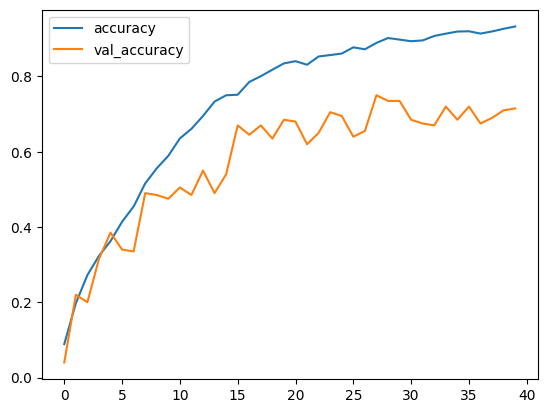

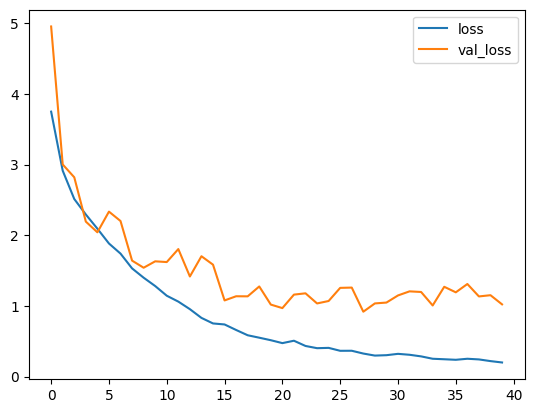

Finish Date Time 24/11/2023 03:54:59


In [51]:
# STEP 10B: Model cnn_modelA
filter_sizes=16
filter_num1=16
filter_num2=16

max_pooling_size=2
drop_out = 0.2
hidden_neuron= 100
epoch_num = 40
modelA = cnn_modelA(filter_sizes, filter_num1, filter_num2, max_pooling_size, hidden_neuron, drop_out)
modelA.summary()

# For the convinence, the dropout value is set to 0.2 first
# In question 3 will test the best model performance by different dropout value


start = timer()
# Fit the model

history = modelA.fit(traindata_full, trainlabel_full, validation_data=(testdata_full, testlabel_full), epochs=epoch_num, batch_size=20, verbose=2)
end = timer()
print('*** Execution time of cnn_modelA = ', (end - start)/60 , ' mins' )
print("Finished training")

scores = modelA.evaluate(testdata_full, testlabel_full, verbose=0)
print("CNN Error: %.2f%%" % (100-scores[1]*100))
print("CNN Accuracy: %.2f%%" % (scores[1]*100))
#
#  Display of results

metrics = history.history
plt.plot(history.epoch, metrics['accuracy'], metrics['val_accuracy'])
plt.legend(['accuracy', 'val_accuracy'])
plt.show()

plt.plot(history.epoch, metrics['loss'], metrics['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.show()

now = datetime.now()
dt_string = now.strftime("%d/%m/%Y %H:%M:%S")  # dd/mm/YY H:M:S
print('Finish Date Time',dt_string)

In [ ]:
# STEP 10C: Test again
scores = modelA.evaluate(testdata_full, testlabel_full, verbose=0)
print("CNN Accuracy: %.2f%%" % (scores[1]*100))

now = datetime.now()
dt_string = now.strftime("%d/%m/%Y %H:%M:%S")  # dd/mm/YY H:M:S
print('Date Time',dt_string)


CNN Accuracy: 61.00%
Date Time 20/11/2023 05:38:23


In [20]:
# STEP 11:  Convolutional Neural Network  (Another example)
# STEP 11A: ModelB
#----------
if mode == 'jupyter':
    from keras.engine.base_layer import regularizers
if mode == 'colab' :
    from keras import regularizers

n_classes = 46
def cnn_modelB():
  model = Sequential()
  model.add(keras.Input(shape=input_shape))
  model.add(keras.layers.Resizing(64,64,interpolation = 'bilinear'))
  # model.add(keras.layers.Resizing(128,128,interpolation = 'bilinear'))  # NOTE the resize()

  # Kernel regularizer parameter
  weight_decay = 1e-4
  # Conv layer part
  model.add(Conv2D(32,(3,3), padding='same' ,activation='relu', kernel_regularizer=regularizers.l2(weight_decay)))
  # model.add(BatchNormalization())
  model.add(MaxPool2D(pool_size = (2,2)))
  # model.add(Dropout(0.2))

  model.add(Conv2D(64,(3,3), padding='same' ,activation='relu', kernel_regularizer=regularizers.l2(weight_decay)))
  # model.add(BatchNormalization())
  model.add(MaxPool2D(pool_size = (2,2)))
  # Dense layer part
  model.add(Flatten())
  model.add(Dense(40,activation='relu'))
  # model.add(BatchNormalization())
  model.add(Dense(n_classes,activation='softmax'))

  if mode == 'jupyter':
    # Optimizer choice setting
    opt_rms = keras.optimizers.RMSprop(learning_rate=0.001, decay=1e-6)
    opt_adam = keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
    # Compile model
    model.compile(loss='categorical_crossentropy', optimizer= opt_adam, metrics=['accuracy'])

  if mode == 'colab':
        model.compile(loss='categorical_crossentropy', optimizer= 'adam', metrics=['accuracy'])

  return model


modelB = cnn_modelB()
modelB.summary()

# modelB = tf.global_variables_initializer()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resizing_1 (Resizing)       (None, 64, 64, 1)         0         
                                                                 
 conv2d_2 (Conv2D)           (None, 64, 64, 32)        320       
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 32, 32, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_3 (Conv2D)           (None, 32, 32, 64)        18496     
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 16, 16, 64)        0         
 g2D)                                                            
                                                                 
 flatten_1 (Flatten)         (None, 16384)            

Epoch 1/30
212/212 - 3s - loss: 4.6694 - accuracy: 0.0474 - val_loss: 3.7647 - val_accuracy: 0.0800 - 3s/epoch - 13ms/step
Epoch 2/30
212/212 - 1s - loss: 3.6698 - accuracy: 0.0858 - val_loss: 3.7487 - val_accuracy: 0.0600 - 668ms/epoch - 3ms/step
Epoch 3/30
212/212 - 1s - loss: 3.5722 - accuracy: 0.0960 - val_loss: 3.6454 - val_accuracy: 0.0650 - 671ms/epoch - 3ms/step
Epoch 4/30
212/212 - 1s - loss: 3.4539 - accuracy: 0.1094 - val_loss: 3.5981 - val_accuracy: 0.1200 - 664ms/epoch - 3ms/step
Epoch 5/30
212/212 - 1s - loss: 3.1102 - accuracy: 0.1693 - val_loss: 3.3432 - val_accuracy: 0.1600 - 664ms/epoch - 3ms/step
Epoch 6/30
212/212 - 1s - loss: 2.6078 - accuracy: 0.2726 - val_loss: 3.0955 - val_accuracy: 0.2250 - 661ms/epoch - 3ms/step
Epoch 7/30
212/212 - 1s - loss: 2.1783 - accuracy: 0.3679 - val_loss: 2.8461 - val_accuracy: 0.2600 - 658ms/epoch - 3ms/step
Epoch 8/30
212/212 - 1s - loss: 1.7455 - accuracy: 0.4708 - val_loss: 2.8326 - val_accuracy: 0.2650 - 656ms/epoch - 3ms/step
Ep

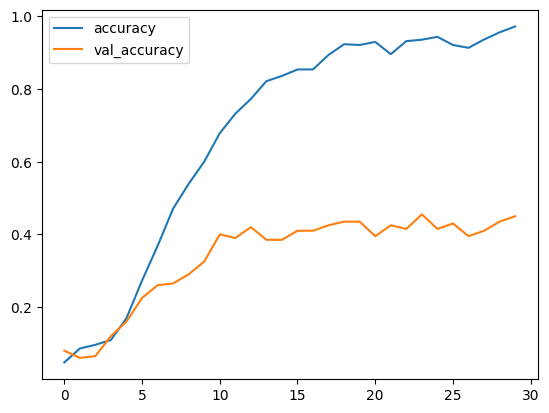

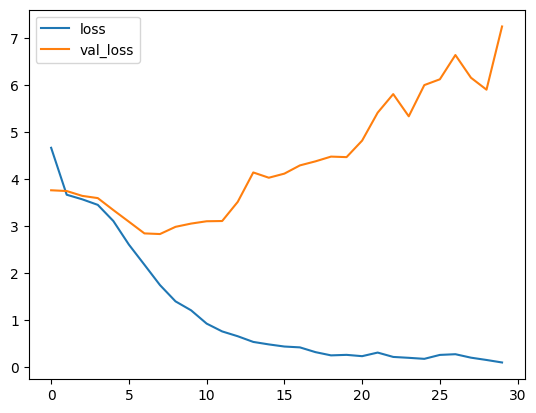

Finish Date Time 23/11/2023 14:19:34


In [21]:
# STEP 11B:
#----------
# ModelB training
start = timer()
epochs_num = 30
history = modelB.fit(traindata_full, trainlabel_full, validation_data=(testdata_full, testlabel_full), epochs=epochs_num, batch_size=20, verbose=2)
end = timer()
print('*** Execution time of cnn_modelB = ', (end - start)/60 , ' mins' )
print("Finished training")

scores = modelB.evaluate(testdata_full, testlabel_full, verbose=0)
print("CNN Error: %.2f%%" % (100-scores[1]*100))
print("CNN Accuracy: %.2f%%" % (scores[1]*100))
#
#  Display of results

metrics = history.history
plt.plot(history.epoch, metrics['accuracy'], metrics['val_accuracy'])
plt.legend(['accuracy', 'val_accuracy'])
plt.show()

plt.plot(history.epoch, metrics['loss'], metrics['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.show()

now = datetime.now()
dt_string = now.strftime("%d/%m/%Y %H:%M:%S")  # dd/mm/YY H:M:S
print('Finish Date Time',dt_string)

In [ ]:

scores = modelB.evaluate(testdata_full, testlabel_full, verbose=0)
print("CNN Error: %.2f%%" % (100-scores[1]*100))
print("CNN Accuracy: %.2f%%" % (scores[1]*100))

CNN Error: 35.33%
CNN Accuracy: 64.67%
